In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [3]:
country_data = pd.read_csv("Country-data.csv")

# Inspecting the data

In [4]:
country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [5]:
country_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [6]:
country_data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


# Data Pre-Processing

In [7]:
# Convert exports,heath,imports columns to absolute values from percentage values
country_data["exports"] = country_data["exports"]*country_data["gdpp"]/100
country_data["health"] = country_data["health"]*country_data["gdpp"]/100
country_data["imports"] = country_data["imports"]*country_data["gdpp"]/100

In [8]:
country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


# EDA

## Univariate Analysis

In [9]:
vis_cols = list(country_data.select_dtypes(include=["float64","int64"]).columns)
vis_cols

['child_mort',
 'exports',
 'health',
 'imports',
 'income',
 'inflation',
 'life_expec',
 'total_fer',
 'gdpp']

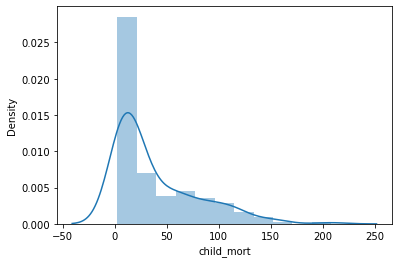

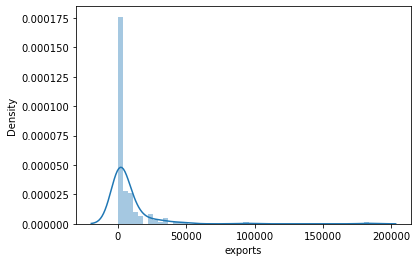

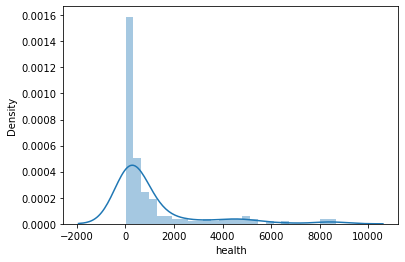

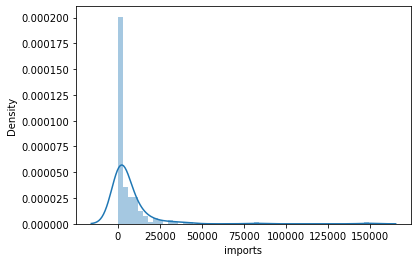

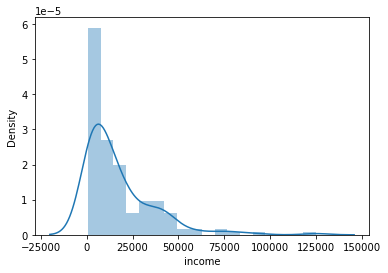

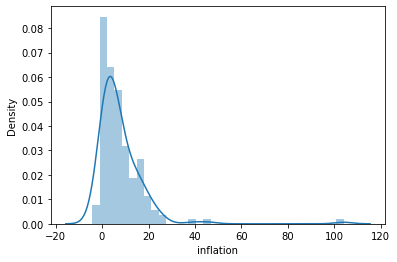

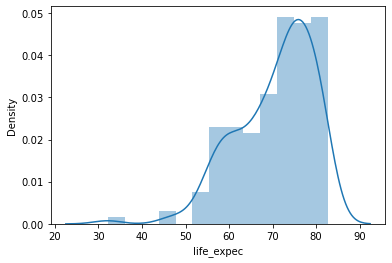

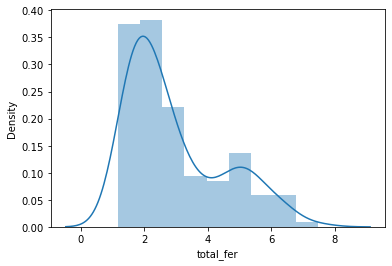

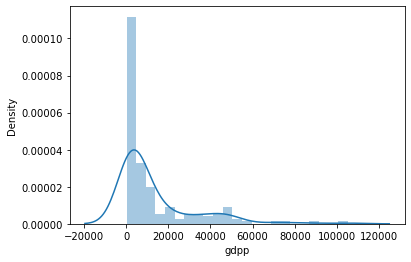

In [10]:
for i in vis_cols:
    sns.distplot(country_data[i],kde=True)
    plt.show()

Most of the variables follow normal distribution with no internal groupings.

Except for variables like income,gdpp,total_fer and life_expec. The distributions indicate some internal groupings and hence indicate some cluster formation.

## Bivariate Analysis

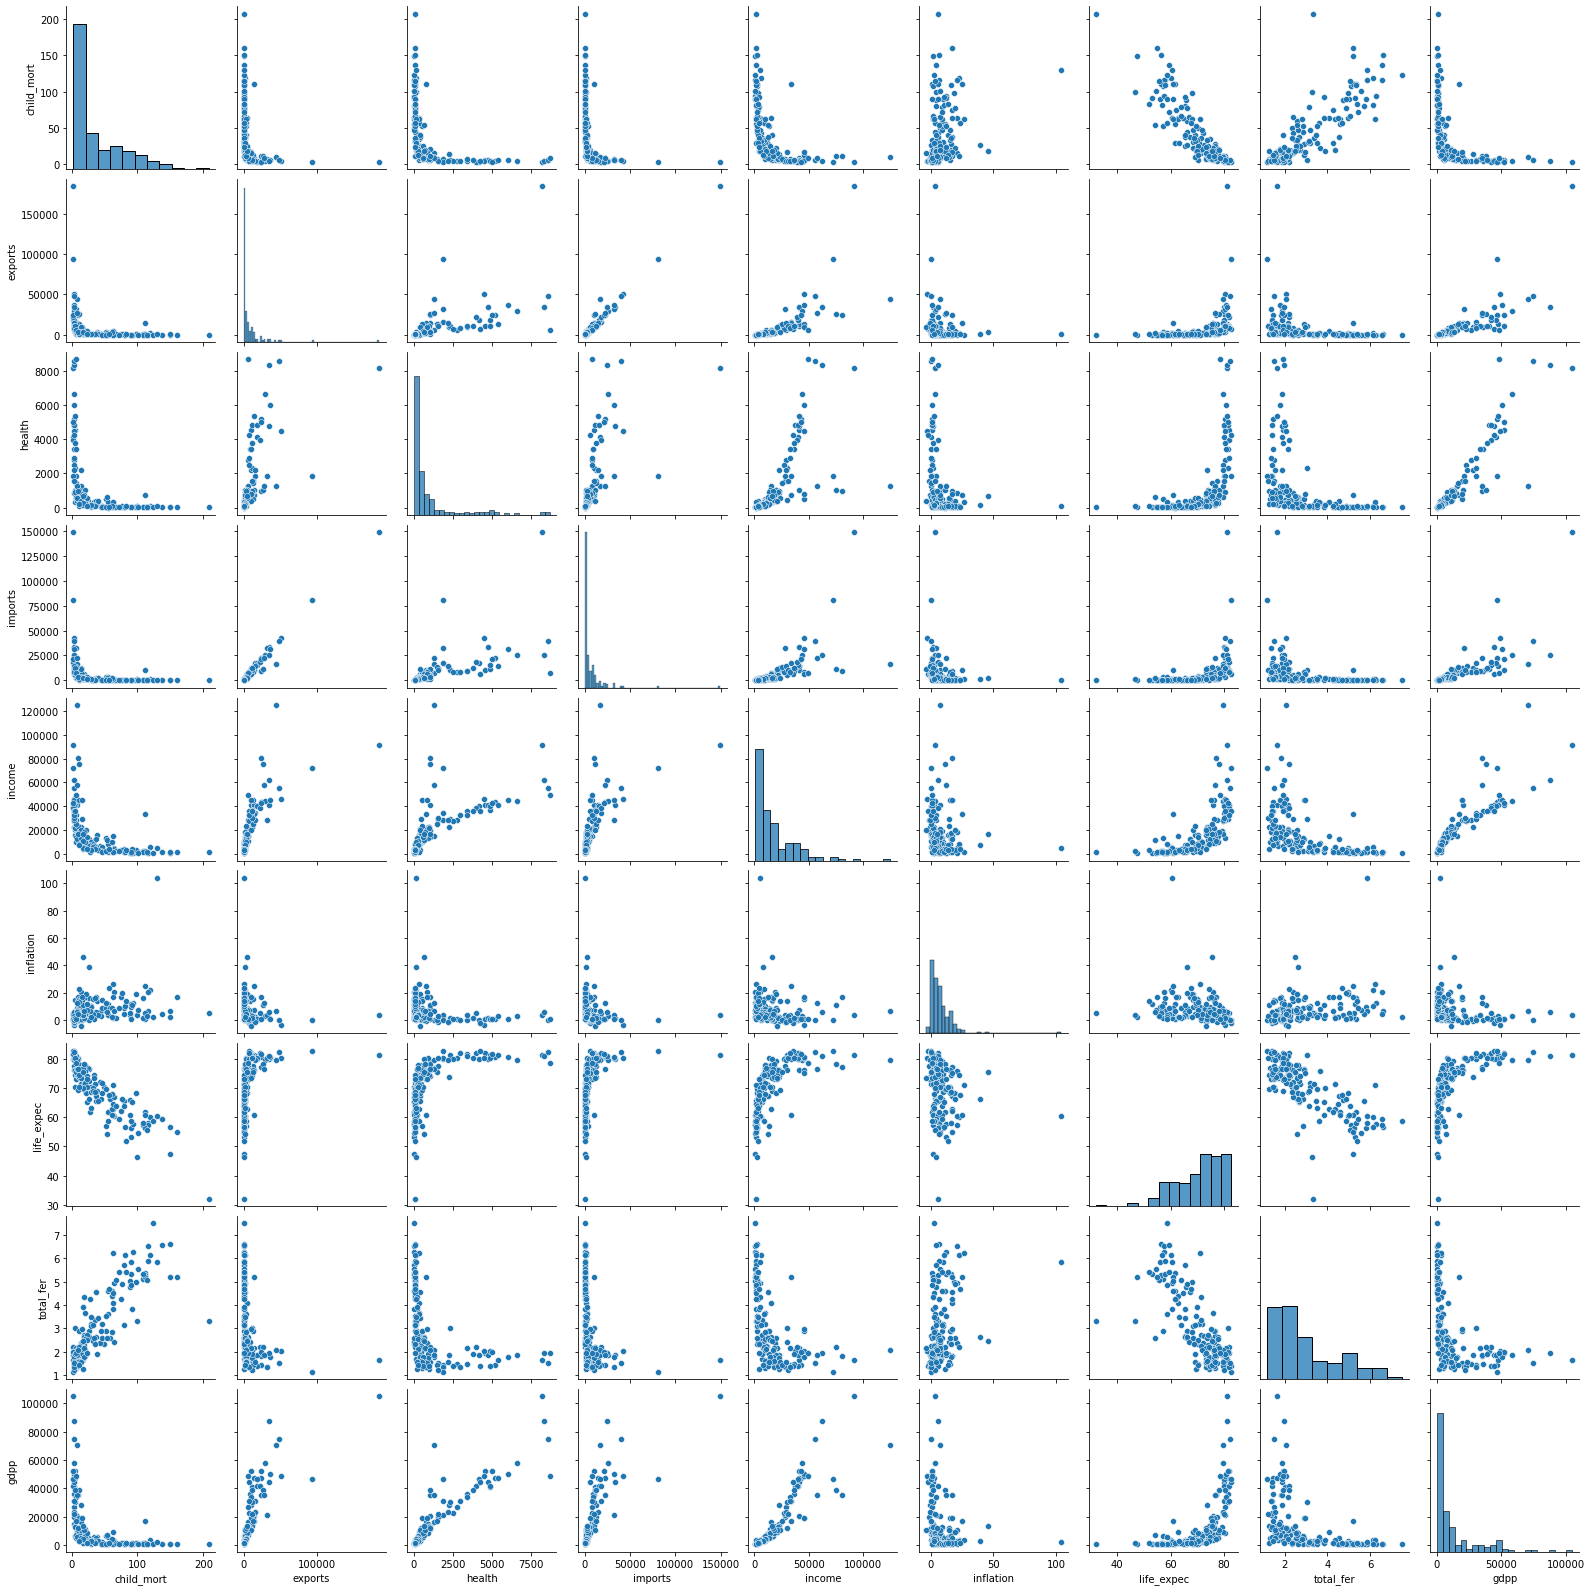

In [11]:
sns.pairplot(country_data)
plt.show()

- gdpp almost follows a linear relationship with variables like exports, health, imports, income. This is obvious in terms that as exports, imports, income increase, gdpp also increases
- We also see that for higher gdpp, the values of life_expec are very high.
- While for higher gdpp, we see values of child_mort and total_fer are very low. 
- As expenditure on health increases, the life_expec also tends to be higher. This is obvious as well.

## Multivariate Analysis, Correlations

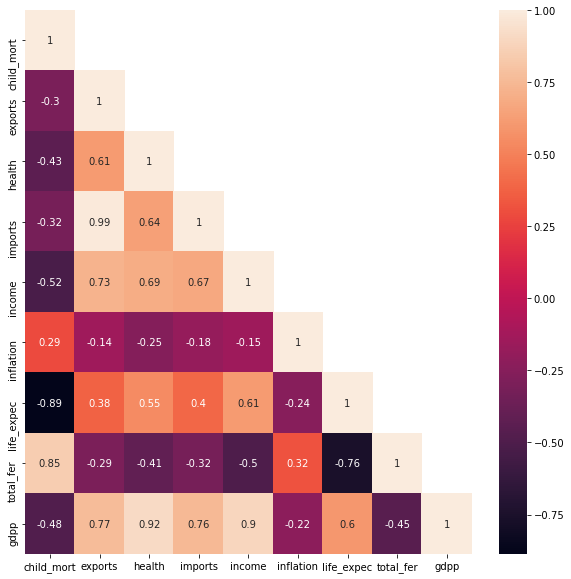

In [12]:
cor = country_data[vis_cols].corr()
mask = np.array(cor)
mask[np.tril_indices_from(mask)] = False
plt.figure(figsize=[10,10])
sns.heatmap(cor,annot=True,mask=mask)
plt.show()

- We see high correlations of variables exports, health, imports, income with gdpp. This is in line with what we saw in bivariate analysis.
- We also see high positive correlations between 
    - exports and imports which is obvious.
    - exports,health and imports with income
- We see negative correlation between
    - child_mort and life_expec :- This is obvious. As child_mortality rate increases, life_expectancy decreases
    - total_fer and life_expec :- This is good information to derive insights from. Maybe as the total_fer increases, it results in population boom, which might be responsible for lowering of life_expec. Maybe because of shortage of resources for each individual.

# Outlier Treatment

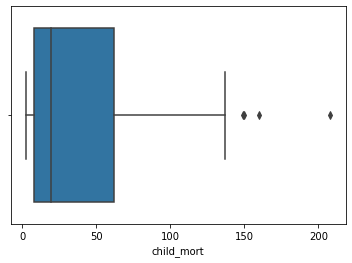

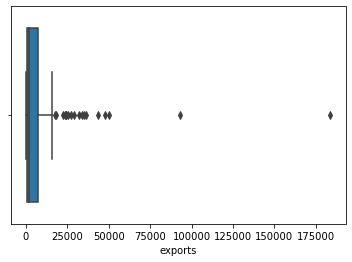

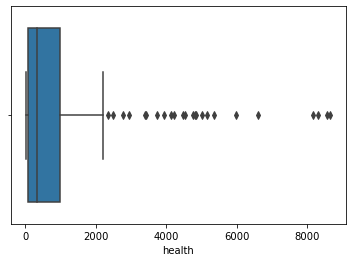

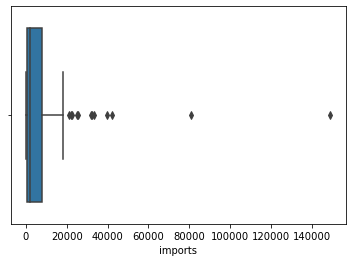

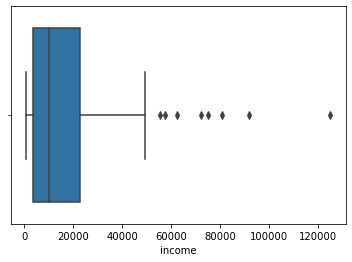

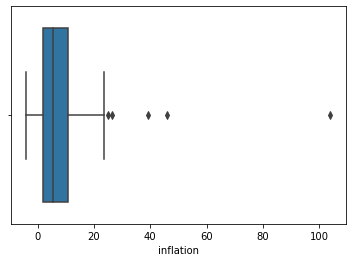

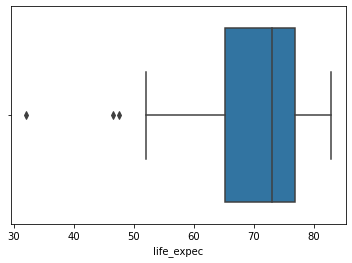

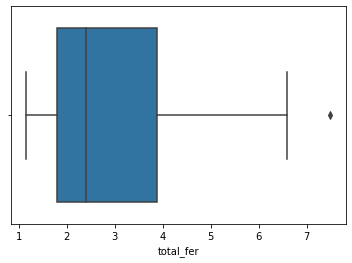

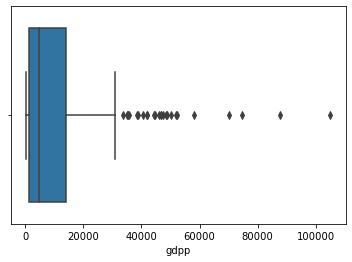

In [13]:
for i in vis_cols:
    sns.boxplot(country_data[i])
    plt.show()

For columns child_mort, inflation and total_fer, we should not treat the higher range outliers as it is critical to our business use case. These columns, if the values are high, suggest that the countries are in dire need of aid. Also we can see that none of these columns have lower range outliers and hence nothing left to do for these columns.

For other columns, we should not treat the lower range outliers for the same reason of them being critical to our business use case. These columns, if the values are low, suggest that the countries are in dire need of aid. 
- We can see that we have lower range outliers for only life_expec column and hence not to do anything.
- While for all other columns except life_expec, child_mort, inflation, total_fer, we have higher range outliers which gives us information but is not critical to our business use case. These countries with higher range outliers for the respective columns seem to be developed countries or at least better in development in comparison with all other countries and therefore not in the priority list of getting any aid.

Since outliers affect cluster centers a lot, the higher range outliers that needs to be treated must be capped using soft capping to a value at 99th percentile

In [14]:
out_cols = ['exports','health','imports','income','gdpp']

for i in out_cols:
    q99 = country_data[i].quantile(0.99)
    country_data[i][country_data[i]>q99] = q99

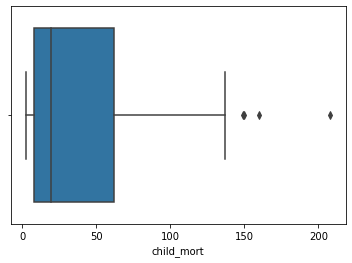

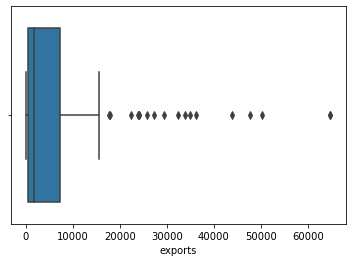

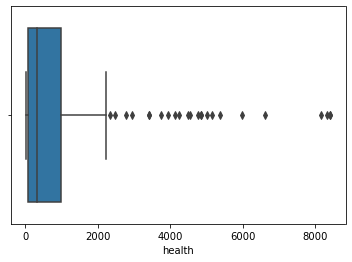

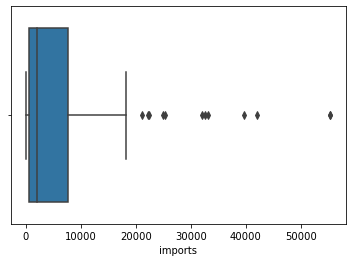

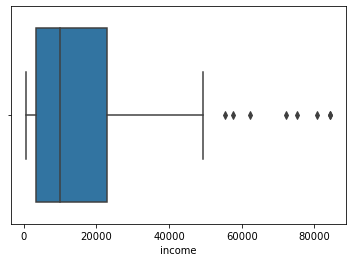

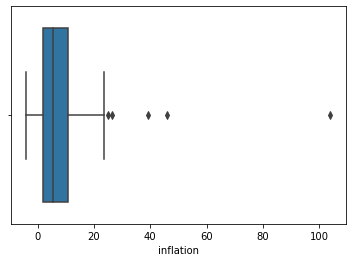

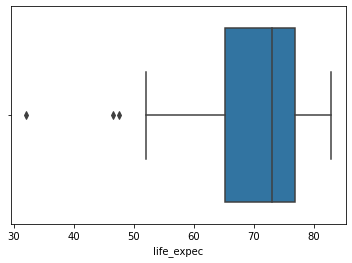

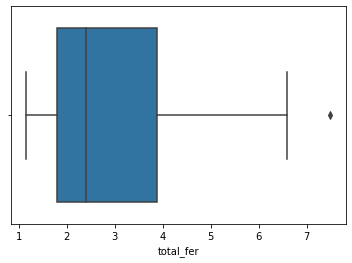

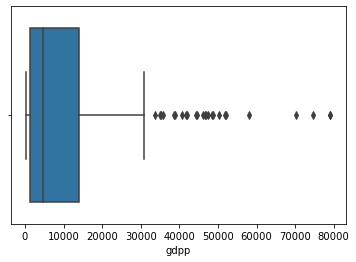

In [15]:
#Checking box-plot again. Since we have use soft capping, we will still see many outliers.
for i in vis_cols:
    sns.boxplot(country_data[i])
    plt.show()

# Checking cluster's tendency - Hopkin's test

In [16]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [17]:
hopkins(country_data.drop("country",axis=1))

0.882318396453956

High value of Hopkins test implies that the data has clusters as compared to a randomly sampled data.

Note:- Value of Hopkins test keeps changing as it compares with random data, but is in the range of 90-95% for this data which tell us high level of dissimilarity between this data and random data.

# Scaling

In [18]:
scaler = StandardScaler()
df1 = scaler.fit_transform(country_data.drop('country',axis=1))
df1

array([[ 1.29153238, -0.56962212, -0.56695778, ..., -1.61909203,
         1.90288227, -0.70225949],
       [-0.5389489 , -0.47385792, -0.4403934 , ...,  0.64786643,
        -0.85997281, -0.49872564],
       [-0.27283273, -0.42399973, -0.48627082, ...,  0.67042323,
        -0.0384044 , -0.47743428],
       ...,
       [-0.37231541, -0.49160668, -0.54024972, ...,  0.28695762,
        -0.66120626, -0.65869853],
       [ 0.44841668, -0.53995007, -0.55242911, ..., -0.34463279,
         1.14094382, -0.65869853],
       [ 1.11495062, -0.52701632, -0.54227159, ..., -2.09278484,
         1.6246091 , -0.6500669 ]])

In [19]:
scaled_country_data = pd.DataFrame(df1)
cols = list(country_data.columns)
cols.remove('country')
scaled_country_data.columns = cols
scaled_country_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.569622,-0.566958,-0.598741,-0.851668,0.157336,-1.619092,1.902882,-0.702259
1,-0.538949,-0.473858,-0.440393,-0.413584,-0.386946,-0.312347,0.647866,-0.859973,-0.498726
2,-0.272833,-0.424000,-0.486271,-0.476100,-0.221053,0.789274,0.670423,-0.038404,-0.477434
3,2.007808,-0.381249,-0.534088,-0.463973,-0.612045,1.387054,-1.179234,2.128151,-0.530950
4,-0.695634,-0.086742,-0.178410,0.139728,0.125254,-0.601749,0.704258,-0.541946,-0.032042


# K Means Clustering

# Finding the best value of k: using Silhouette score, SSD

## Silhouette scores

In [20]:
from sklearn.metrics import silhouette_score

ss = []
for k in range(2,11):
    kmeans = KMeans(n_clusters = k).fit(scaled_country_data)
    ss.append([k, silhouette_score(scaled_country_data, kmeans.labels_)])

ss

[[2, 0.4785840154547689],
 [3, 0.4225082959293209],
 [4, 0.4083536290370275],
 [5, 0.4146964405516596],
 [6, 0.3158051449254877],
 [7, 0.3207500292427783],
 [8, 0.3149535229988031],
 [9, 0.2812072902529189],
 [10, 0.2713016459547601]]

In [21]:
sil_scores = pd.DataFrame(ss)
sil_scores

,0,1
0,2,0.478584
1,3,0.422508
2,4,0.408354
3,5,0.414696
4,6,0.315805
5,7,0.320750
6,8,0.314954
7,9,0.281207
8,10,0.271302


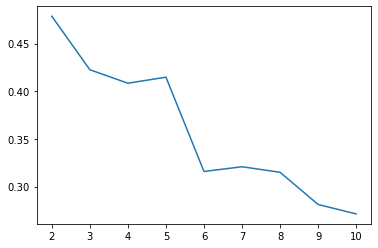

In [22]:
plt.plot(sil_scores[0],sil_scores[1])
plt.show()

k=2 has the highest silhoutte score. We take the next best, which k=3.

## SSD

In [23]:
ssd = []
for k in range(2,11):
    kmeans = KMeans(n_clusters = k).fit(scaled_country_data)
    ssd.append([k, kmeans.inertia_])

ssd

[[2, 851.7336991398662],
 [3, 561.643633976162],
 [4, 449.85514573642257],
 [5, 370.59738753045093],
 [6, 327.97006349549514],
 [7, 296.40273717452203],
 [8, 270.3484146667439],
 [9, 245.396579768222],
 [10, 223.9592631281435]]

In [24]:
ssd_values = pd.DataFrame(ssd)
ssd_values

,0,1
0,2,851.733699
1,3,561.643634
2,4,449.855146
3,5,370.597388
4,6,327.970063
5,7,296.402737
6,8,270.348415
7,9,245.396580
8,10,223.959263


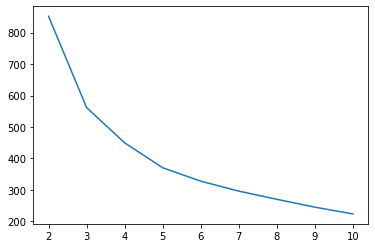

In [25]:
plt.plot(ssd_values[0],ssd_values[1])
plt.show()

The above plot is an elbow curve. We see that the bend or slope of line decreases at k=3. According to SSD, too the ideal number of clusters are 3.

# Final clustering with k=3 and k+-1

k=2 clusters doesn't make much sense. Hence we will only go with k=3 and k=4 clusters.

## K=3

In [26]:
kmeans3 = KMeans(n_clusters=3, random_state=0)
kmeans3.fit(scaled_country_data)

KMeans(n_clusters=3, random_state=0)

In [27]:
#Centroids
kmeans3.cluster_centers_

array([[ 1.32661038, -0.49724204, -0.52612588, -0.53713716, -0.72390519,
         0.39181237, -1.27627565,  1.3543418 , -0.62421756],
       [-0.82514582,  1.74867521,  1.85335572,  1.7215187 ,  1.79855215,
        -0.44230208,  1.11738206, -0.77703072,  1.99793841],
       [-0.44998219, -0.25376753, -0.26941915, -0.22498284, -0.15014629,
        -0.0746178 ,  0.33795561, -0.47857149, -0.26067276]])

In [28]:
kmeans3.labels_

array([0, 2, 2, 0, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 0,
       2, 1, 2, 0, 0, 2, 0, 1, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 1, 2,
       1, 2, 2, 2, 2, 0, 0, 2, 2, 1, 1, 0, 0, 2, 1, 0, 2, 2, 2, 0, 0, 2,
       0, 2, 1, 2, 2, 2, 0, 1, 2, 1, 2, 1, 2, 2, 0, 0, 1, 2, 0, 2, 2, 0,
       0, 2, 2, 1, 2, 0, 0, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2,
       1, 1, 0, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 0, 2, 2,
       0, 1, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 1, 1, 2, 0, 2, 0, 0, 2, 2, 2,
       2, 0, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0])

In [29]:
country_data_3clus = country_data.copy()
country_data_3clus['labels'] = kmeans3.labels_
country_data_3clus.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,2
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,2
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,2


## K=4

In [30]:
kmeans4 = KMeans(n_clusters=4, random_state=0)
kmeans4.fit(scaled_country_data)

KMeans(n_clusters=4, random_state=0)

In [31]:
#Centroids
kmeans4.cluster_centers_

array([[-0.40073015, -0.3477249 , -0.37432605, -0.32776224, -0.30044547,
        -0.02762071,  0.26115828, -0.44695248, -0.39099425],
       [-0.84237107,  3.38505949,  2.51076791,  3.21669774,  2.37841226,
        -0.53228173,  1.1566476 , -0.78341088,  2.78938863],
       [ 1.32661038, -0.49724204, -0.52612588, -0.53713716, -0.72390519,
         0.39181237, -1.27627565,  1.3543418 , -0.62421756],
       [-0.80125156,  0.70733581,  1.08677385,  0.76844277,  1.24591255,
        -0.39356005,  0.99862468, -0.74005033,  1.20458285]])

In [32]:
kmeans4.labels_

array([2, 0, 0, 2, 0, 0, 0, 3, 3, 0, 3, 3, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2,
       0, 3, 0, 2, 2, 0, 2, 3, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 3, 3,
       1, 0, 0, 0, 0, 2, 2, 0, 0, 3, 3, 2, 2, 0, 3, 2, 3, 0, 0, 2, 2, 0,
       2, 0, 3, 0, 0, 0, 2, 1, 3, 3, 0, 3, 0, 0, 2, 2, 3, 0, 2, 0, 0, 2,
       2, 0, 0, 1, 0, 2, 2, 0, 0, 2, 3, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       1, 3, 2, 2, 1, 3, 2, 0, 0, 0, 0, 0, 3, 1, 0, 0, 2, 0, 3, 2, 0, 0,
       2, 1, 3, 3, 2, 2, 3, 3, 0, 0, 2, 0, 3, 1, 0, 2, 0, 2, 2, 0, 0, 0,
       0, 2, 0, 3, 3, 3, 0, 0, 0, 0, 0, 2, 2])

In [33]:
country_data_4clus = country_data.copy()
country_data_4clus['labels'] = kmeans4.labels_
country_data_4clus.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,2
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,2
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0


# Visualising and analysing clusters using scatter plots for variables gdpp, child_mort, income

## K=3

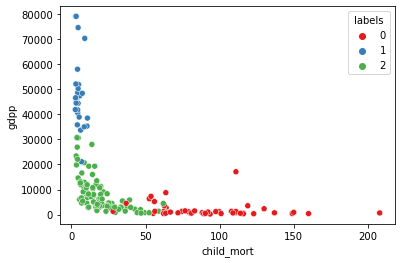

In [34]:
# gdpp v/s child_mort
sns.scatterplot(x='child_mort',y='gdpp',hue='labels',data=country_data_3clus,palette='Set1')
plt.show()

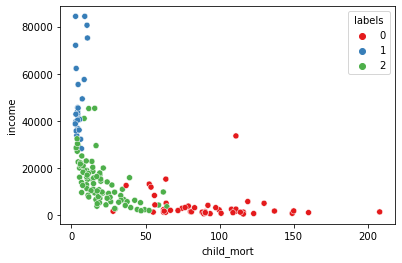

In [35]:
#child_mort v/s income
sns.scatterplot(x='child_mort',y='income',hue='labels',data=country_data_3clus,palette='Set1')
plt.show()

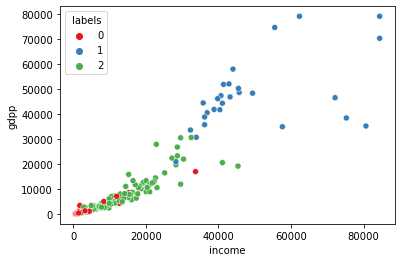

In [36]:
#gdpp v/s income
sns.scatterplot(x='income',y='gdpp',hue='labels',data=country_data_3clus,palette='Set1')
plt.show()

## K=4

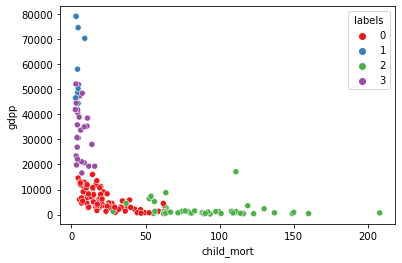

In [37]:
# gdpp v/s child_mort
sns.scatterplot(x='child_mort',y='gdpp',hue='labels',data=country_data_4clus,palette='Set1')
plt.show()

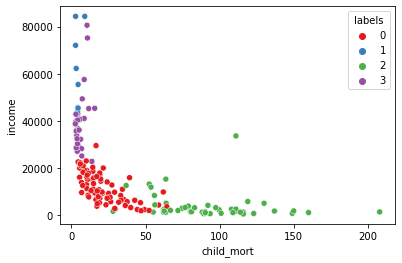

In [38]:
#child_mort v/s income
sns.scatterplot(x='child_mort',y='income',hue='labels',data=country_data_4clus,palette='Set1')
plt.show()

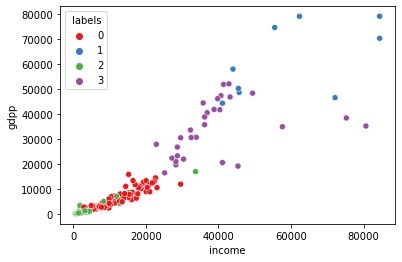

In [39]:
#gdpp v/s income
sns.scatterplot(x='income',y='gdpp',hue='labels',data=country_data_4clus,palette='Set1')
plt.show()

# Cluster Profiling

## k = 3

In [40]:
country_data_3clus[['gdpp','child_mort','income','labels']].groupby('labels').mean()

,gdpp,child_mort,income
labels,,,
0,1909.208333,91.610417,3897.354167
1,47476.888889,5.092593,49057.333333
2,8226.869565,20.177174,14169.456522


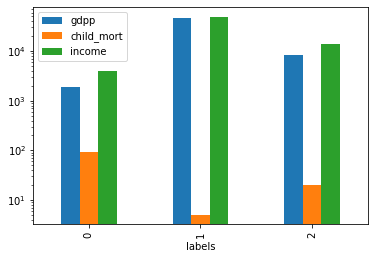

In [41]:
country_data_3clus[['gdpp','child_mort','income','labels']].groupby('labels').mean().plot(kind='bar')
plt.yscale("log")
plt.show()

The cluster with label 0 is the ideal cluster for our business use case. It has lowest gdpp, highest child_mort, and lowest income in average amongst all other clusters. The countries in this cluster are the ones in dire need of aid.

## k = 4

In [42]:
country_data_4clus[['gdpp','child_mort','income','labels']].groupby('labels').mean()

,gdpp,child_mort,income
labels,,,
0,5962.150000,22.157500,11478.625000
1,61230.666667,4.400000,59438.666667
2,1909.208333,91.610417,3897.354167
3,33690.000000,6.053333,39163.333333


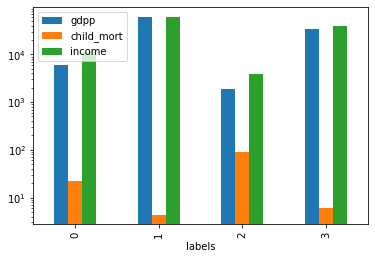

In [43]:
country_data_4clus[['gdpp','child_mort','income','labels']].groupby('labels').mean().plot(kind='bar')
plt.yscale("log")
plt.show()

Here cluster 2 is the ideal cluster for our business use case. It has lowest gdpp, highest child_mort, and lowest income in average amongst all other clusters. The countries in this cluster are the ones in dire need of aid.

#### Since for k=4 clusters, silhouette score is less than k=3 clusters and while visualising the clusters as well, for k=3 the information captured is clearly distinguishable and is able to capture information in 3 clusters only, there is no need for a 4th cluster. We will go ahead with 3 clusters only. 

# Identifying the countries in dire need of aid(using k means clustering)
Clusters = 3 \
Ideal cluster for our use case = Cluster 0 

In [44]:
cluster_final = country_data_3clus[country_data_3clus['labels']==0]
cluster_final.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels
0,Afghanistan,90.2,55.300,41.9174,248.297,1610.0,9.440,56.2,5.82,553.0,0
3,Angola,119.0,2199.190,100.6050,1514.370,5900.0,22.400,60.1,6.16,3530.0,0
17,Benin,111.0,180.404,31.0780,281.976,1820.0,0.885,61.8,5.36,758.0,0
21,Botswana,52.5,2768.600,527.0500,3257.550,13300.0,8.920,57.1,2.88,6350.0,0
25,Burkina Faso,116.0,110.400,38.7550,170.200,1430.0,6.810,57.9,5.87,575.0,0


In [45]:
cluster_final.sort_values(by=['gdpp','child_mort','income'],ascending=[True,False,True]).head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.26,231.0,0
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.02,327.0,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.54,334.0,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,7.49,348.0,0
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.20,399.0,0


Top 5 countries in dire need of aid on the basis of gdpp, child_mort and income(using k-means clustering) are
1. Burundi
2. Liberia
3. Congo, Dem. Rep.
4. Niger
5. Sierra Leone

# Hierarchical Clustering

In [46]:
scaled_country_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.569622,-0.566958,-0.598741,-0.851668,0.157336,-1.619092,1.902882,-0.702259
1,-0.538949,-0.473858,-0.440393,-0.413584,-0.386946,-0.312347,0.647866,-0.859973,-0.498726
2,-0.272833,-0.424000,-0.486271,-0.476100,-0.221053,0.789274,0.670423,-0.038404,-0.477434
3,2.007808,-0.381249,-0.534088,-0.463973,-0.612045,1.387054,-1.179234,2.128151,-0.530950
4,-0.695634,-0.086742,-0.178410,0.139728,0.125254,-0.601749,0.704258,-0.541946,-0.032042


## Single Linkage

In [47]:
mergings = linkage(scaled_country_data,method='single',metric='euclidean')

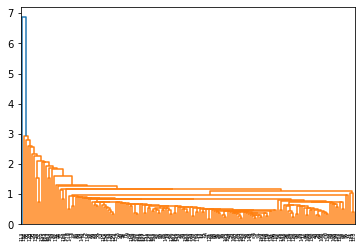

In [48]:
dendrogram(mergings)
plt.show()

The dendrogram is not clearly interpretable. Hence we will go forward with Complete Linkage only.

## Complete Linkage

In [49]:
mergings = linkage(scaled_country_data,method='complete',metric='euclidean')

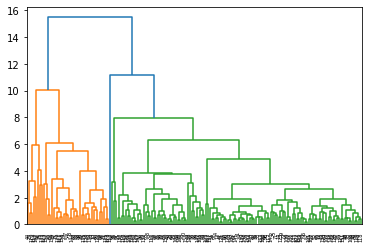

In [50]:
dendrogram(mergings)
plt.show()

In [51]:
cluster2_labels = cut_tree(mergings,n_clusters=2).reshape(-1,)
cluster2_labels

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [52]:
cluster3_labels = cut_tree(mergings,n_clusters=3).reshape(-1,)
cluster3_labels

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [53]:
cluster4_labels = cut_tree(mergings,n_clusters=4).reshape(-1,)
cluster4_labels

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 1, 0, 3, 2, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 2, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

- If we see the cluster labels for k=3 and k=4, we see only 1 point in the last cluster. One point cannot constitute a cluster.
- Also if we interpret the dendrogram, for k=2, it has the maximum vertical distance as shown in below figure as compared to k=3 or k=4

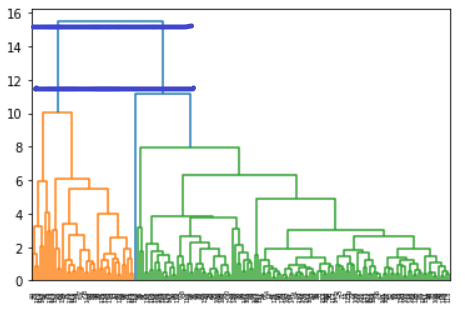

## Visualising clusters for k=2

In [54]:
country_data_hie_2clus = country_data.copy()
country_data_hie_2clus['labels'] = cluster2_labels
country_data_hie_2clus.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.82,553.0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.65,4090.0,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.89,4460.0,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,22.40,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.13,12200.0,0


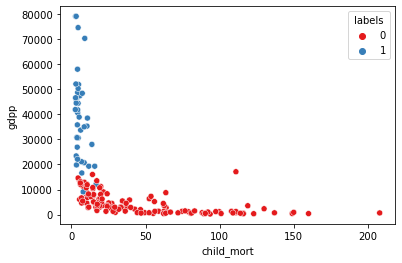

In [55]:
# gdpp v/s child_mort
sns.scatterplot(x='child_mort',y='gdpp',hue='labels',data=country_data_hie_2clus,palette='Set1')
plt.show()

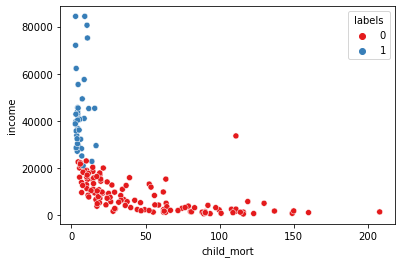

In [56]:
#child_mort v/s income
sns.scatterplot(x='child_mort',y='income',hue='labels',data=country_data_hie_2clus,palette='Set1')
plt.show()

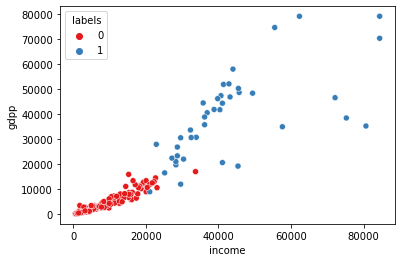

In [57]:
#gdpp v/s income
sns.scatterplot(x='income',y='gdpp',hue='labels',data=country_data_hie_2clus,palette='Set1')
plt.show()

## Cluster Profiling

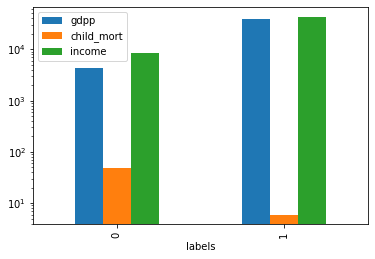

In [58]:
country_data_hie_2clus[['gdpp','child_mort','income','labels']].groupby('labels').mean().plot(kind='bar')
plt.yscale("log")
plt.show()

The cluster with label 0 is the ideal cluster for our business use case. It has lowest gdpp, highest child_mort, and lowest income in average amongst all other clusters. The countries in this cluster are the ones in dire need of aid.

# Identifying the countries in dire need of aid(using hierarchical clustering)
Clusters = 2 \
Ideal cluster for our use case = Cluster 0 

In [59]:
cluster_final_hie = country_data_hie_2clus[country_data_hie_2clus['labels']==0]
cluster_final_hie.head(40)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels
0,Afghanistan,90.2,55.3000,41.9174,248.297,1610.0,9.440,56.2,5.82,553.0,0
1,Albania,16.6,1145.2000,267.8950,1987.740,9930.0,4.490,76.3,1.65,4090.0,0
2,Algeria,27.3,1712.6400,185.9820,1400.440,12900.0,16.100,76.5,2.89,4460.0,0
3,Angola,119.0,2199.1900,100.6050,1514.370,5900.0,22.400,60.1,6.16,3530.0,0
4,Antigua and Barbuda,10.3,5551.0000,735.6600,7185.800,19100.0,1.440,76.8,2.13,12200.0,0
5,Argentina,14.5,1946.7000,834.3000,1648.000,18700.0,20.900,75.8,2.37,10300.0,0
6,Armenia,18.1,669.7600,141.6800,1458.660,6700.0,7.770,73.3,1.69,3220.0,0
9,Azerbaijan,39.2,3171.1200,343.3920,1208.880,16000.0,13.800,69.1,1.92,5840.0,0
12,Bangladesh,49.4,121.2800,26.6816,165.244,2440.0,7.140,70.4,2.33,758.0,0
13,Barbados,14.2,6320.0000,1275.2000,7792.000,15300.0,0.321,76.7,1.78,16000.0,0


In [59]:
cluster_final_hie.sort_values(by=['gdpp','child_mort','income'],ascending=[True,False,True]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,6.26,231.0,0
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.02,327.0,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,6.54,334.0,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,7.49,348.0,0
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.20,399.0,0
93,Madagascar,62.2,103.2500,15.5701,177.590,1390.0,8.79,60.8,4.60,413.0,0
106,Mozambique,101.0,131.9850,21.8299,193.578,918.0,7.64,54.5,5.56,419.0,0
31,Central African Republic,149.0,52.6280,17.7508,118.190,888.0,2.01,47.5,5.21,446.0,0
94,Malawi,90.5,104.6520,30.2481,160.191,1030.0,12.10,53.1,5.31,459.0,0
50,Eritrea,55.2,23.0878,12.8212,112.306,1420.0,11.60,61.7,4.61,482.0,0


Top 5 countries in dire need of aid on the basis of gdpp, child_mort and income(using hierarchical clustering) are
1. Burundi
2. Liberia
3. Congo, Dem. Rep.
4. Niger
5. Sierra Leone

# Final Results

Using K-means we categorized the countries in 3 clusters and using Hierarchical clustering, we categorized the countries in 2 clusters, both giving the same final results.

The final list of 5 countries which are in dire need of aid are
1. Burundi
2. Liberia
3. Congo, Dem. Rep.
4. Niger
5. Sierra Leone

Even if we take top 10 countries, both K-means and Hierarchical clustering gives same list of countries
1. Burundi
2. Liberia
3. Congo, Dem. Rep.
4. Niger
5. Sierra Leone
6. Madagascar
7. Mozambique
8. Central African Republic
9. Malawi
10. Eritrea